In [28]:
%matplotlib inline
import pandas as pd
import numpy as np
import nivapy3 as nivapy
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score
from sklearn.feature_selection import RFECV
from collections import OrderedDict

plt.style.use('ggplot')

# Feature importances for WaterXr

Rough code for estimating feature importances using a Random Forest. The most complicated part of this workflow is deciding how to handle NaNs in a sensible way. This is because the sampling strategy at Vansjø is strongly biased over time (sampling only takes place between spring and autumn). This produces regular periods of NaNs in the data series, which affect the calculations for lagged variables.

## 1. Read data

In [47]:
# Variable of interest. Choose from 'TP', 'Chl-a', 'CyanoBiovol'. These need to match the data matrix file names
variable = 'CyanoBiovol'

# Basin of interest. Choose from 'Van1' (Storefjorden) or 'Van2' (Vanemfjorden)
basin = 'Van2'

# Dict to translate from variable name used in filename, to that used in column name for picking out target var
target_var_dict = {'TP':'tp_lake',
                  'Chl-a': 'chl-a_lake',
                  'CyanoBiovol': 'cyanobiovol'}

target_var = target_var_dict[variable]

# Read Leah's data matrix
in_csv = r'../data/DataMatrices/dataMatrix_monthly_%s_%s.csv' %(variable, basin)
df = pd.read_csv(in_csv)

# Parse dates and tidy
df['Date'] = pd.to_datetime(df['Date'])
df.columns = df.columns.str.lower()
df.set_index('date', inplace=True)

df.head()

,pptn,temp,wind_speed,pet,q,tp_catch,chl-a_lake,tp_lake,colour_lake,cyanobiovol,...,temp_lag2m_av,temp_lag3m_av,q_lag2m_av,q_lag3m_av,season,chl-a_lake_prevsummer,tp_lake_prevsummer,cyanobiovol_prevsummer,chl-a_van1_prevsummer,tp_van1_prevsummer
date,,,,,,,,,,,,,,,,,,,,,
1996-06-30,64.535699,13.291172,4.200000,107.890312,2.109759,46.15,16.50,27.60,22.0,0.120,...,5.911567,3.295424,5.720338,3.896419,summ,25.55,29.65,NaN,10.075,24.95
1996-07-31,27.760550,14.767498,3.790323,121.381906,0.649900,69.56,27.65,32.40,19.5,3.125,...,10.629672,8.371436,4.365734,4.516812,summ,25.55,29.65,NaN,10.075,24.95
1996-08-31,71.153706,16.901620,3.303226,111.855029,0.404032,47.80,22.80,33.40,18.0,4.230,...,14.029335,12.008947,1.379829,3.127123,summ,25.55,29.65,NaN,10.075,24.95
1996-09-30,81.099450,8.795539,2.643333,60.312718,0.808759,116.55,16.60,30.95,13.5,4.235,...,15.834559,14.986763,0.526966,1.054564,aut,25.55,29.65,NaN,10.075,24.95
1997-06-30,71.985996,15.500207,3.576667,118.458466,0.787966,36.78,15.40,22.20,27.0,0.180,...,6.367938,4.893140,3.093306,3.436419,summ,23.65,31.45,2.65,7.250,17.45


## 2. Encode variables

In addition to continuous variables, we also have two kinds of categorical variable: **ordinal** and **nominal**. Ordinal data consists of *ordered* classes, such as water quality status where e.g. `'HG'` represents higher quality than `'M'`, which is higher than `'PB'`. The nominal categories are *unordered* (month and season, for example). 

### 2.1. Ordinal data

I will reclassify water quality status using an integer scale, where 0 corresponds to `'PB'` and 2 corresponds to `'HG'`.

In [50]:
# Category mappings
status_dict = {'HG':2,
               'M':1,
               'PB':0}

# Columns with ordinal data
ord_cols = ['status_tp_lake', 'status_tp_lake_lag1m', 'status_tp_lake_prevsummer']

# # Reclassify
# for col in ord_cols:
#     df[col] = df[col].replace(status_dict)

### 2.2. Nominal

The nominal data can be represented using "[one hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)", which generates $(n - 1)$ binary features from a column with $n$ categories.

In [51]:
# One hot encoding for nominal columns
df = pd.get_dummies(df, 
                    {'month':'month',
                     'season':'season'},
#                      'season_2':'season2'},
                    columns=['month', 'season'],#, 'season_2'],
                    drop_first=True)

In [52]:
df.columns

Index(['pptn', 'temp', 'wind_speed', 'pet', 'q', 'tp_catch', 'chl-a_lake',
       'tp_lake', 'colour_lake', 'cyanobiovol',
       ...
       'chl-a_van1_prevsummer', 'tp_van1_prevsummer', 'month_5', 'month_6',
       'month_7', 'month_8', 'month_9', 'month_10', 'season_spr',
       'season_summ'],
      dtype='object', length=154)

## 3. Filling missing data

Most ML algorithms don't like missing data. The code below calculates the proportion of missing values in each column.

In [53]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = 100 * missing['total'] / len(df)
missing.sort_values('percent', ascending=False).head(20)

,total,percent
colour_van1_lag1m,50,40.0
colour_van1,38,30.4
tp_van1_lag1m,31,24.8
tp_lake_lag1m,31,24.8
colour_lake_lag1m,30,24.0
chl-a_van1_lag1m,25,20.0
colour_lake,25,20.0
chl-a_lake_lag1m,25,20.0
cyanobiovol_lag1m,23,18.4
tp_catch_lag3m_av,15,12.0


First, decide to drop colour and TP in van1, given almost 50% missing data

In [54]:
drop_features = ['colour_van1_lag1m', 'colour_van1', 'tp_van1_lag1m']

df = df.drop(drop_features, axis=1)

For the rest, filling these gaps sensibly is not easy. In the code below, I've used the following strategy:

 1. For **continuous** variables, fill missing values with the *median* for the month in question
 
 2. For **Ordinal** variables, fill missing values with the most common (i.e. modal) value for the month in question
 
There are no missing values for the **nominal** variables, since they're all derived from the date-time index, which is complete.

**Note:** Filling NaNs in this way transfers information between samples (i.e. rows) in the dataset. This violates the assumption that each row can be treated as an independent sample and may bias the model evaluation performed below. Ideally, we would retain a completely independent testing dataset for final model evaluation, but we don't have enough data for that here.

In [55]:
# loop over columns
for col in df.columns:
    if col in ord_cols:
        # Ordinal data. Get modal value for each month
        patch = df.groupby(df.index.month)[col].apply(pd.Series.mode).loc[:, 0]

    else:
        # Contiuous data. Get median value for each month
        patch = df.groupby(df.index.month)[col].median()
        
    # Loop over rows
    for idx, row in df.iterrows():
        if pd.isnull(row[col]):
            try:
                # Try to fill with patches value for this month
                fill_val = patch.loc[idx.month]
                df.loc[idx, col] = fill_val
            except KeyError:
                # No data available for this month. Leave as NaN
                pass

How effective has this startegy been at filling NaNs?

In [56]:
# Pct missing
missing = pd.DataFrame(df.isnull().sum()).rename(columns = {0: 'total'})
missing['percent'] = 100 * missing['total'] / len(df)
missing.sort_values('percent', ascending=False).head(10)

,total,percent
chl-a_lake_lag1m,9,7.2
chl-a_van1_lag1m,9,7.2
cyanobiovol_lag1m,9,7.2
tp_lake_lag1m,9,7.2
wind_under_q0.5_lag6m_sum,0,0.0
wind_under_q0.4_lag5m_sum,0,0.0
wind_under_q0.4_lag6m_sum,0,0.0
wind_under_q0.5_lag2m_sum,0,0.0
wind_under_q0.5_lag3m_sum,0,0.0
wind_under_q0.5_lag4m_sum,0,0.0


In [57]:
# Decide to drop the lag1m lake variables, rather than dropping the rows which don't have data for these (i.e start of season values)
drop_features2 = missing.sort_values('percent', ascending=False).index.values[:4]
drop_features2

array(['chl-a_lake_lag1m', 'chl-a_van1_lag1m', 'cyanobiovol_lag1m',
       'tp_lake_lag1m'], dtype=object)

This is better. For the remaining NaNs, I could either fill values using the overall mean/median for each column, drop the feature, or simply drop the rows that still contain NaN. For the rest I'll dorp the NaNs rather than apply more arbitrary data patching.
 
## 4. Random forest modelling

### 4.1. Drop any remaining NaNs

In [58]:
df2 = df.drop(drop_features2, axis=1).dropna(how='any')
print('Length of original dataset:', len(df))
print('Length of trimmed dataset: ', len(df2))

Length of original dataset: 125
Length of trimmed dataset:  125


### 4.2. Fit model


In [59]:
# Define response vars (target variable defined at the start)
exp_vars = [i for i in df2.columns if i != target_var]

Random Forests use "bootstrapping" to partition the data used by each tree. Data not included in each bootstrap sample can therefore be used to perform "internal" validation, without the need for a holdout dataset as is usual for cross-validation. This approach is usually referred to as the "out-of-bag" (OOB) validation score. In sci-kit learn, this is roughly equivalent to $R^2$, but calculated on "unseen" data (as opposed to the less stringent "within-sample" $R^2$ typically reported for OLS regression).

OOB scores are not *exactly* the same as cross-validation but, under typical circumstances, the OOB score should be roughly comparable to 3-fold CV (see e.g. [here](https://stats.stackexchange.com/a/199201/5467) and [here](https://stats.stackexchange.com/a/208018/5467) for some discussion). When using OOB scores, it is not necessary to split the data into training and testing sets, which is a big advantage when data are limited (as is the case here). Ideally, validation using a test set should also be performed, but for the work here I'm going to focus on OOB scores in order to make the most of limited data.

Random Forests have a number of hyperparameters that can be tuned to improve performance. Of these, the most important seem to be `'n_estimators'` (the number of treesin the forest) and `'max_features'` (the size of the random subsets of features to consider when splitting a node). There is some debate about the best values to choose for `'max_features'`: the default for regression problems in sci-kit learn is `'max_features' = 'n_features'`, whereas in R the recommended value is to use about one third of the total number of features (see the comments on [this](https://stackoverflow.com/a/23950648/505698) post and the references in the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) for details).

The code below (modified from [here](https://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html)) plots the OOB error rate (= `1 - OOB_Score`) as a function of `'n_estimators'` for various choices for `'max_features'`. 

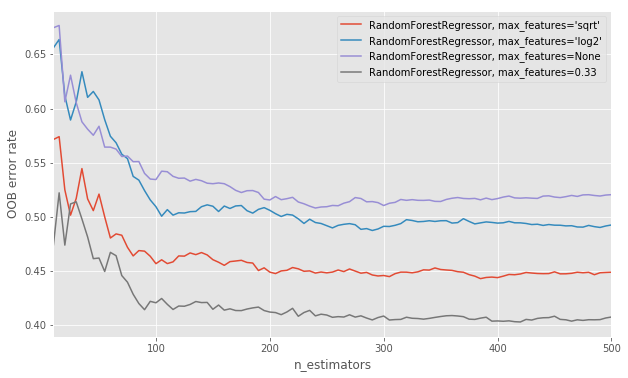

In [61]:
# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# For reproducibility
rand_state = 42

# List classifiers of interest
# NB: Setting the `warm_start=True` disables parallel support, but is necessary for 
# tracking the OOB error trajectory during training
ensemble_clfs = [
    ("RandomForestRegressor, max_features='sqrt'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              oob_score=True,
                              max_features="sqrt",
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features='log2'",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features='log2',
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=None",                  
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=None,           # Default. Uses all feats
                              oob_score=True,
                              random_state=rand_state)),
    ("RandomForestRegressor, max_features=0.33",
        RandomForestRegressor(n_estimators=100,
                              warm_start=True, 
                              max_features=0.33,           # Older recommendation. Used by R
                              oob_score=True,
                              random_state=rand_state))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore
min_estimators = 10
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        clf.set_params(n_estimators=i)
        clf.fit(X_scaled, y)

        # Record the OOB error 
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot
fig = plt.figure(figsize=(10,6))
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")

To pick the best parameters to use in the models below, pick the curve in the above plot which has the lowest error rate, and pick n_estimators where the curve has flattened out (or reached a minimum?)

### 4.3. Feature importances

In [65]:
# Set based on graph above
n_estimators = 200
max_features = 0.33

# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=n_estimators,
                              warm_start=False, 
                              max_features=max_features,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.59


,importance
chl-a_lake,0.207437
colour_lake_lag1m,0.066537
colour_lake,0.064645
tp_van1,0.043899
cyanobiovol_prevsummer,0.033752
chl-a_lake_prevsummer,0.028931
tp_lake,0.025940
pet_lag1m,0.024129
tp_catch,0.019316
tp_lake_prevsummer,0.016527


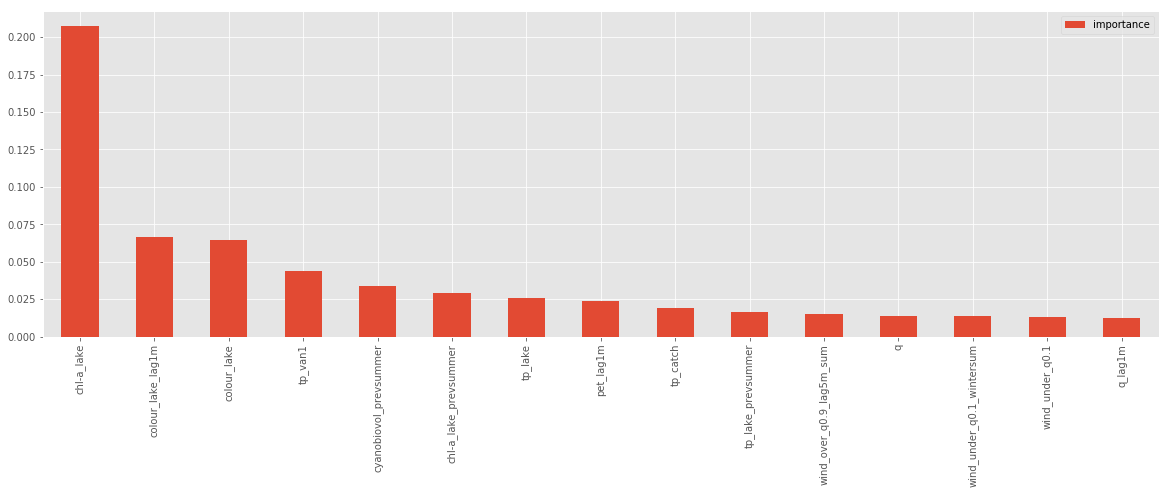

In [66]:
# Plot
res_df[:15].plot(kind='bar', figsize=(20,6))

Good OOB score

Based on this, the features to look further at are something like:

 * chl-a_lake. But that's only because they are both likely controlled by the same thing? Same as van1
 * lake colour (current and previous month, though the two are extremely auto-correlated)
 * tp in van1, maybe also 
 * cyanobiovol and chl-a in the previous summer (makes sense, and nice to see this coming out)


### 4.5. Recursive feature elimination

Recursive feature elimination attempts to find the best model using subsets of the available features. This is essentially the same as "stepwise" regression, except here we're using CV to avoid overfitting (as opposed to traditional "significance testing"). In the code below, I've used out-of-sample $R^2$ as a measure of performance. The best values obtained are pretty low, but remember that out-of-sample tests are much more stringent than their within-sample equivalents. The best overall indicator of perfornmance used in this notebook is the OOB score.

**Note:** Other scoring metrics are available. Use 

    sorted(sklearn.metrics.SCORERS.keys())
    
to print a list.

Optimal number of features: 1

Optimal features (in no particular order):
   chl-a_lake


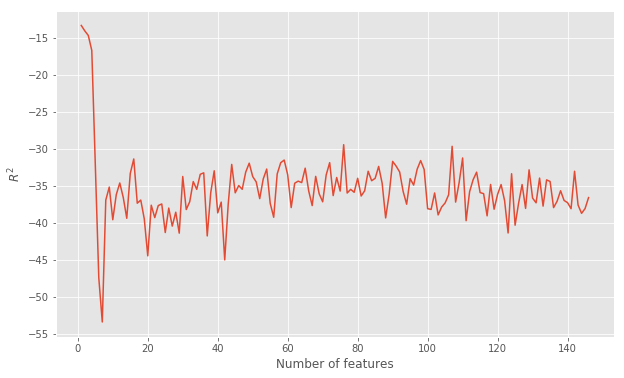

In [67]:
# Build same model as above
model = RandomForestRegressor(n_estimators=n_estimators,
                              warm_start=False, 
                              max_features=max_features,           
                              oob_score=True,
                              random_state=rand_state)

# Feature elimination with 3-fold CV
rfecv = RFECV(estimator=model, 
              step=1, 
              cv=3, 
              scoring='r2',
              n_jobs=-1)

selector = rfecv.fit(X_scaled, y)

print('Optimal number of features: %d' % rfecv.n_features_)
print('')
print ('Optimal features (in no particular order):')
for i in np.array(exp_vars)[selector.support_]:
    print('  ', i)
    
# Plot number of features vs. cross-validation score
plt.figure(figsize=(10,6))
plt.xlabel('Number of features')
plt.ylabel('$R^2$')
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)

Use the plot to decide roughly how many features to pick before things level off. Then think about which features are likeley to contain duplicate information. Lets try a consolidated list, removing duplicated features, and see how that model performs.

Hmmm, this looks like it's failed. Not sure why?! So just explore results by picking the top few features identified earlier as being important

In [83]:
# Reduce list of exp vars based on results above
exp_vars = [
   'colour_lake_lag1m',
   'chl-a_lake',
    'cyanobiovol_prevsummer',
#     'wind_under_q0.5'
#     'chl-a_lake_prevsummer',
           ]


# Extract vars
y = df2[target_var]
X = df2[exp_vars]

# Standardise exp vars
scalar = StandardScaler()
X_scaled = pd.DataFrame(scalar.fit_transform(X), 
                        index=X.index, 
                        columns=X.columns)

# Build model using 'best' results from above
model = RandomForestRegressor(n_estimators=n_estimators,
                              warm_start=False, 
                              max_features=max_features,           
                              oob_score=True,
                              random_state=rand_state)
model.fit(X_scaled, y)

print ('OOB score: %.2f' % model.oob_score_)

# Get importance scores
res_df = pd.DataFrame({'importance':model.feature_importances_}, 
                      index=X.columns.values).sort_values(by='importance',
                                                          ascending=False)
res_df.head(10)

OOB score: 0.70


,importance
chl-a_lake,0.429746
colour_lake_lag1m,0.324547
cyanobiovol_prevsummer,0.245707


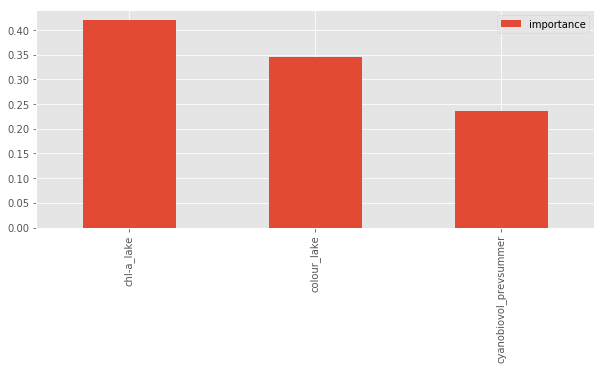

In [32]:
# Plot
res_df[:15].plot(kind='bar', figsize=(10,4))

## Summary

This seems a bit unstable (failure of recursive feature selection algorithm, and some other suspicious behaviour). But assuming results are right, can get an OOB of 0.7 using **chl-a, lake colour and cyanobiovol from the previous summer**.

Wind variables haven't come out as being important for whatever reason, even though analysis done elsewhere (Jannicke, and other studies) suggests that only get cyanobacterial blooms when it's both warm and calm. Perhaps looking at the wrong wind variable? Rather than total count of calm days per month, should be boolean for whether it has min. number of consecutive calm days required for bloom? But then what's 'calm' in terms of wind speed, and what's the minimum number of days? One thing to consider is that the algal data is from a 0-4m sample, i.e. not that far off the full depth of the lake in many places. So many not tell you whether you have a surface bloom. During a bloom, are overall concs over 0-4m higher than during non-blooms? Or is it just that everyone is at the surface?

Can actually do ok with just met variables too (though I deleted that cell...).